LSTM for expressive dynamics prediction
---------------

This notebook loads the data generated from the pre-processing notebook and uses them to train and test a long short-term memory artificial neural network for predicting the three parabolic coefficients that approximate the dynamics of phrases from the dataset pieces.


#### Load and preprocess training data

In [102]:
import numpy as np
import pandas as pd

np.random.seed(1728)

#  read csvs
instruments = ['violin', 'viola', 'cello', 'flute']
alldf = []
for ins in instruments:
  # for running locally:
  path = open('data/' + ins + '.csv', 'r')
  # for running in colab:
  #path = "https://github.com/fabiozeh/deep-motifs/blob/master/data/" + ins + ".csv?raw=true"
  df = pd.read_csv(path)
  df.drop(['Unnamed: 0'], axis=1, inplace=True)
  print('initial size (' + ins + '): ' + str(len(df)))
  df['instrument'] = ins
  alldf.append(df)

df = pd.concat(alldf, ignore_index=True)
# eliminate missing values, insufficient dynamics data (dynamicsX0 = -inf)
df.dropna()
df = df.loc[df.dynamicsX0 != -np.inf,:]

print('size after N/A crop: ' + str(len(df)))

initial size (violin): 25516
initial size (viola): 11933
initial size (cello): 11207
initial size (flute): 1273
size after N/A crop: 49896


In [103]:
def sequencer(df):
  sequences = []
  maxLen = 0
  #  list the instruments
  instruments = set(df.instrument)
  for ins in instruments:
    # list the pieces
    di = df.loc[df.instrument == ins, :]
    pieces = set(di.pieceId)
    for p in pieces:
      d = di.loc[di.pieceId == p, :]
      #  use only the smaller phrases
      d = d.loc[np.concatenate((np.asarray([True]),(np.diff(d.locationInPiece) > 1e-7))), :]
      #d = d.loc[d.motifId.map(lambda x: x.split('_')[-1]) == '0', :]
      maxLen = len(d) if len(d) > maxLen else maxLen
      d = d.drop(['instrument', 'pieceId', 'motifId', 'locationInPiece', 'pieceDynMean', 'pieceDynStd', 'pieceKey', 'startTime', 'durationSecs'], axis=1)
      #  standardize features
      moments = np.zeros((3,2)) # output mean and std for reverting predictions
      outs = d.loc[:,['dynamicsX2','dynamicsX1','dynamicsX0']]
      moments[:,0] = outs.mean().to_numpy()
      moments[:,1] = outs.std().to_numpy()
      nums = d.loc[:,(d.dtypes == 'float64') | (d.dtypes == 'int64')]
      d.loc[:, (d.dtypes == 'float64') | (d.dtypes == 'int64')] = (nums - nums.mean()) / nums.std()
      y = d.loc[:, ['dynamicsX2','dynamicsX1','dynamicsX0']]
      d = d.drop(['dynamicsX2','dynamicsX1','dynamicsX0'], axis=1)
      sequences.append((moments, d, y))
  X = np.full((len(sequences), maxLen, len(sequences[0][1].columns)), 0, dtype='float64')
  Y = np.full((len(sequences), maxLen, len(sequences[0][2].columns)), 0, dtype='float64')
  moments = np.zeros((len(sequences), 3, 2))
  pd_idx = np.full((len(sequences), maxLen), -1e4, dtype='int32')
  for i, s in enumerate(sequences):
      (mm, x, y) = s
      X[i, 0:len(x), :] = x
      Y[i, 0:len(y), :] = y
      moments[i, :, :] = mm
      pd_idx[i, 0:len(x)] = x.index
  return X, Y, moments, pd_idx
        
def filter_outliers(df, cols=None, outlier_factor=5.):
    if cols is None:
        cols = (df.dtypes == 'float64') | (df.dtypes == 'int64')
    numdf = df.loc[:, cols]
    thold = outlier_factor * (numdf.quantile(0.75) - numdf.quantile(0.25))
    return df[((numdf - thold) < 0).all(axis=1)]

#  one-hot encode nominal values
for attrib in ['metricStrength', 'pieceMode', 'initialChord', 'finalChord']:
    df = pd.concat([df, pd.get_dummies(df[attrib], prefix=attrib)], axis=1)
    df.drop([attrib], axis=1, inplace=True)

#  make data sequential 
X, Y, moments, pd_idx = sequencer(df)
print("dataset size: " + str(X.shape))

nans = np.argwhere(np.isnan(X))
nan_idx = pd_idx[[a[0] for a in nans]]
rows = set([nan_idx[i][nans[i][1]] for i in range(len(nan_idx))])
culprits = df.loc[rows,['pieceId', 'instrument', 'motifId', 'startTime', 'locationInPiece', 'numberOfNotes', 'rhythmContourX0']]
print(culprits)

#  eliminate NaNs
okrows = np.logical_not(np.logical_or(np.isnan(X).any(axis=(1,2)), np.isnan(Y).any(axis=(1,2))))
X = X[okrows,:,:]
Y = Y[okrows,:,:]
moments = moments[okrows,:,:]
pd_idx = pd_idx[okrows,:]
print("dataset size without NaN: " + str(X.shape))

dataset size: (328, 291, 46)
dataset size without NaN: (325, 291, 46)


#### Define the neural network

In [109]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, BatchNormalization, Dense, TimeDistributed

model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(16, return_sequences = True)),
    Dropout(0.8),
    BatchNormalization(),
    TimeDistributed(Dense(3)),
    BatchNormalization()])

opt = keras.optimizers.Adam(learning_rate=1e-4, clipnorm=0.001)
model.compile(loss="mean_absolute_error", optimizer='adam')

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 291, 32)           8064      
_________________________________________________________________
dropout_12 (Dropout)         (None, 291, 32)           0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 291, 32)           128       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 291, 3)            99        
_________________________________________________________________
batch_normalization_25 (Batc (None, 291, 3)            12        
Total params: 8,303
Trainable params: 8,233
Non-trainable params: 70
_________________________________________________________________


#### Train the model

In [ ]:
model.fit(X[10:,:,:], Y[10:,:,:], epochs=300, validation_split=0.1)

#### Results

In [ ]:
#  Save model
model.save_weights('2020-07-22.h5')

In [122]:
# Load model
model.load_weights('2020-07-22-17hs.h5')

#  Compute note-level error
xval_s = 10
Yhat = model.predict(X[0:xval_s,:,:])
DynPieces = []
DynIdeal = []
DynHat = []
RMSE_ideal = 0
RMSE_pred = 0
RMS_pieces = 0
for choice in range(0,xval_s):
    d_piece = np.load('data/levels/'+ str(df.pieceId[pd_idx[choice][0]]) + '_global_lvls.npy')
    DynPieces.append(d_piece)
    valid_idx = pd_idx[choice][pd_idx[choice] > 0]
    ideal = np.zeros((len(d_piece),2))
    hat = np.zeros((len(d_piece),2))
    cur_idx = 0
    for phr in range(len(valid_idx)):
        duration = df.durationSecs[valid_idx[phr]]
        t0 = df.startTime[valid_idx[phr]]
        n = int(duration * 10)
        tref = np.linspace(0, 1, n)
        x2_ref = df.dynamicsX2[valid_idx[phr]]
        x1_ref = df.dynamicsX1[valid_idx[phr]]
        x0_ref = df.dynamicsX0[valid_idx[phr]]
        x2_hat = Yhat[choice, phr, 0] * moments[choice,0,1] + moments[choice,0,0]
        x1_hat = Yhat[choice, phr, 1] * moments[choice,1,1] + moments[choice,1,0]
        x0_hat = Yhat[choice, phr, 2] * moments[choice,2,1] + moments[choice,2,0]
        ideal[cur_idx:cur_idx + n, 0] = tref*duration + t0
        ideal[cur_idx:cur_idx + n, 1] = x2_ref*tref**2 + x1_ref*tref + x0_ref
        hat[cur_idx:cur_idx + n, 0] = tref*duration + t0
        hat[cur_idx:cur_idx + n, 1] = x2_hat*tref**2 + x1_hat*tref + x0_hat
        cur_idx += n
    DynIdeal.append(ideal)
    DynHat.append(hat)
    RMSE_ideal += np.sqrt(np.mean((ideal[:,1] - d_piece)**2)) / xval_s
    RMSE_pred += np.sqrt(np.mean((hat[:,1] - d_piece)**2)) / xval_s
    RMS_pieces += np.sqrt(np.mean(d_piece**2)) / xval_s
    
print('Ideal approximation note-level RMS Error: ' + str(RMSE_ideal))
print('Prediction note-level RMS Error: ' + str(RMSE_pred))
print('Mean performance RMS loudness: ' + str(RMS_pieces))

Ideal approximation note-level RMS Error: 0.9499571381615812
Prediction note-level RMS Error: 1.0082776537558638
Mean performance RMS loudness: 0.9999999821186065


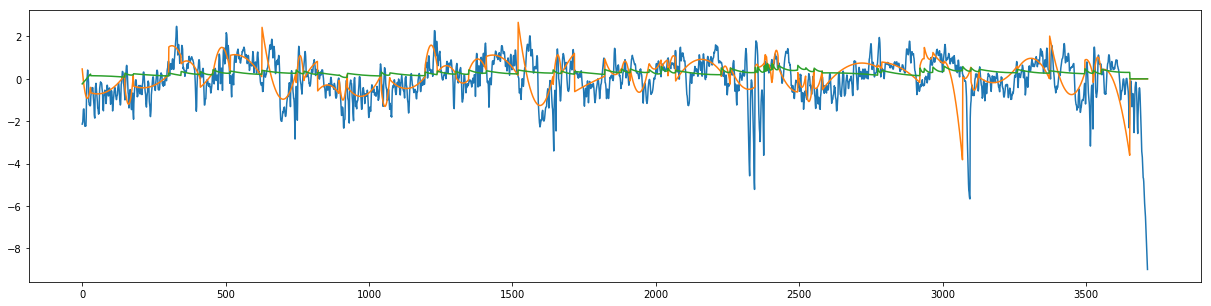

In [127]:
import matplotlib.pyplot as plt

choice = 3
plt.figure(figsize=(21, 5))
#plt.plot(np.asarray(list(range(0, len(DynPiece))), dtype='float64') / 10.0, DynPiece)
#plt.plot(DynIdeal[:,0], DynIdeal[:,1])
#plt.plot(DynHat[:,0], DynHat[:,1])
plt.plot(DynPieces[choice])
plt.plot(DynIdeal[choice][:,1])
plt.plot(DynHat[choice][:,1])
plt.show()